In [1]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2.2.2+cu118
CUDA available: True


In [2]:
import os
from typing import Dict, Any, List, Tuple
ROOT = os.path.expanduser("~/plant_disease")
DATA_DIR = os.path.join(ROOT, "data")
MODEL_DIR = os.path.join(ROOT, "models")
IMG_DIR   = os.path.join(ROOT, "images")
print(os.listdir(DATA_DIR))

['plant_disease_text_finetune_val.jsonl', 'leaf_cutouts', 'management_kb.json', 'plant_disease_text_finetune_train_aug15_merged.jsonl', 'kb_leaf_spots.json', 'test_images', 'last_weather_feats.json', 'plant_disease_text_finetune_val_aug15_merged.jsonl', 'plant_disease_text_finetune_train.jsonl']


In [2]:
# One-time reset: clean reinstall a known-good Ultralytics build
import sys, subprocess, shutil, sysconfig
from pathlib import Path

def sh(*args):
    print(">>", " ".join(args))
    subprocess.run(list(args), check=True)

# Uninstall and remove any leftover package folders
try:
    sh(sys.executable, "-m", "pip", "uninstall", "-y", "ultralytics")
except subprocess.CalledProcessError:
    pass

site_pkgs = Path(sysconfig.get_paths()["purelib"])
for name in ["ultralytics", "ultralytics-*.dist-info", "ultralytics-*.egg-info"]:
    for p in site_pkgs.glob(name):
        shutil.rmtree(p, ignore_errors=True)

# Install a single, consistent version (works well for YOLOv8-seg)
sh(sys.executable, "-m", "pip", "install", "--no-cache-dir", "-q", "ultralytics==8.3.200")
sh(sys.executable, "-m", "pip", "install", "--no-cache-dir", "-q", "roboflow", "matplotlib", "Pillow")


KeyboardInterrupt: 

In [ ]:
# ===== Cell 1: Setup & Dataset =====
API_KEY   = "UxJNgB6Bckpo9y8cb1xn"
WORKSPACE = "ugalab"
PROJECT   = "leaf-spot-disease"
VERSION   = 9
IMGSZ     = 1024  # match your Roboflow export

import platform, yaml, pprint, glob, os
from pathlib import Path
import torch

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Python:", platform.python_version())

from roboflow import Roboflow
rf = Roboflow(api_key=API_KEY)
project = rf.workspace(WORKSPACE).project(PROJECT)
version  = project.version(VERSION)
dataset  = version.download("yolov8")     # segmentation export
DATA_YAML = f"{dataset.location}/data.yaml"

print("\nDataset at:", dataset.location)
print("\n===== data.yaml =====")
print(Path(DATA_YAML).read_text())

cfg = yaml.safe_load(Path(DATA_YAML).read_text())
print("\nParsed data.yaml:\n"); pprint.pprint(cfg)

# Sanity checks
assert set(map(str.lower, cfg["names"])) == {"leaf","spot"}, f"Classes must be ['leaf','spot'], got {cfg['names']}"
train_dir = Path(dataset.location) / "train"
val_dir   = Path(dataset.location) / "valid"
if not val_dir.exists():
    val_dir = Path(dataset.location) / "val"
assert train_dir.exists(), f"Missing train split at {train_dir}"
assert val_dir.exists(),   f"Missing val/valid split at {val_dir}"
print("\nSanity checks passed ✅")

Torch: 2.6.0+cu126
CUDA available: True
GPU: NVIDIA GeForce RTX 3090
Python: 3.10.12
loading Roboflow workspace...
loading Roboflow project...

Dataset at: /home/myid/bp67339/plant_disease/notebooks/Leaf-spot-disease-9

===== data.yaml =====
names:
- leaf
- spot
nc: 2
roboflow:
  license: CC BY 4.0
  project: leaf-spot-disease
  url: https://universe.roboflow.com/ugalab/leaf-spot-disease/dataset/9
  version: 9
  workspace: ugalab
test: ../test/images
train: ../train/images
val: ../valid/images


Parsed data.yaml:

{'names': ['leaf', 'spot'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'leaf-spot-disease',
              'url': 'https://universe.roboflow.com/ugalab/leaf-spot-disease/dataset/9',
              'version': 9,
              'workspace': 'ugalab'},
 'test': '../test/images',
 'train': '../train/images',
 'val': '../valid/images'}

Sanity checks passed ✅


In [ ]:
from ultralytics import YOLO

# Path to your trained weights
BEST_PT = "/home/myid/bp67339/plant_disease/notebooks/runs/segment/train6/weights/best.pt"

# Load model
model = YOLO(BEST_PT)

# Validate on the validation split
metrics = model.val(
    data=DATA_YAML,
    imgsz=IMGSZ,
    task="segmxent",   # segmentation mode
    conf=0.001        # low conf so predictions aren't filtered too strictly
)

# Print results
print("—— Segmentation metrics ——")
print(f"mAP@0.5      : {metrics.seg.map50:.4f}")
print(f"mAP@0.5:0.95 : {metrics.seg.map:.4f}")
print(f"Precision    : {metrics.seg.mp:.4f}")
print(f"Recall       : {metrics.seg.mr:.4f}")

metrics_dict = metrics.results_dict
print(metrics_dict)

Ultralytics 8.3.200 🚀 Python-3.10.12 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3090, 24260MiB)


YOLO11n-seg summary (fused): 113 layers, 2,834,958 parameters, 0 gradients, 9.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3916.9±986.5 MB/s, size: 134.5 KB)
val: Scanning /home/myid/bp67339/plant_disease/notebooks/Leaf-spot-disease-9/valid/labels.cache... 101 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 101/101 161.0Kit/s 0.0s
val: /home/myid/bp67339/plant_disease/notebooks/Leaf-spot-disease-9/valid/images/PXL_20240702_183838590_jpg.rf.0b8309863ca06418196b3c2306817747.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.1it/s 6.3s1.2ss
                   all        101       5900      0.752      0.686      0.743      0.485      0.735      0.651      0.722       0.44
                  leaf        101        688      0.732      0.737      0.788      0.579      0.742      0.725      0.785      0.565
                  spot        101

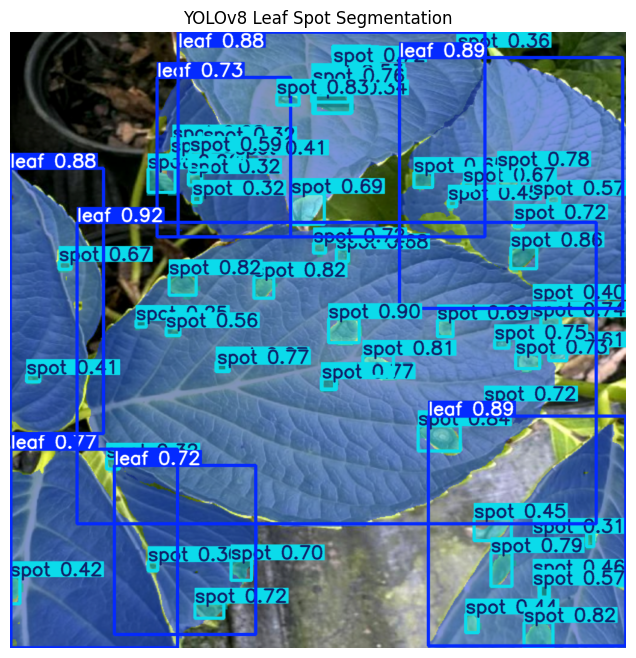

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# --- Config ---
BEST_PT = "/home/myid/bp67339/plant_disease/notebooks/runs/segment/train7/weights/best.pt"
IMG_PATH = "/home/myid/bp67339/plant_disease/notebooks/Leaf-spot-disease-9/test/images/20240626_173421646_iOS_jpg.rf.19d2ed0e820ddc207a4eb56694cb28b8.jpg"

# --- Load Model ---
model = YOLO(BEST_PT)

# --- Predict ---
results = model.predict(
    source=IMG_PATH,
    conf=0.25,
    imgsz=640,
    verbose=False
)

# --- Show overlay inline ---
overlay_bgr = results[0].plot()     # returns BGR image with segmentation overlay
overlay_rgb = overlay_bgr[..., ::-1]  # convert to RGB for matplotlib

plt.figure(figsize=(8, 8))
plt.imshow(overlay_rgb)
plt.axis("off")
plt.title("YOLOv8 Leaf Spot Segmentation")
plt.show()

Per-leaf spot coverage (% of each leaf area):
  leaf# 0:  5.307%  (leaf_px=117,924, spot∩leaf_px=6,258)
  leaf# 2:  5.236%  (leaf_px=28,322, spot∩leaf_px=1,483)
  leaf# 3:  2.490%  (leaf_px=40,287, spot∩leaf_px=1,003)
  leaf# 4:  1.696%  (leaf_px=19,751, spot∩leaf_px=335)
  leaf# 6: 11.170%  (leaf_px=37,232, spot∩leaf_px=4,159)
  leaf#16:  0.237%  (leaf_px=25,341, spot∩leaf_px=60)
  leaf#18: 10.007%  (leaf_px=12,031, spot∩leaf_px=1,204)
  leaf#32:  0.717%  (leaf_px=12,272, spot∩leaf_px=88)

=== Overall (area-weighted across all leaves) ===
Total leaf pixels:      293,160
Total spot-on-leaf px:  14,590
Overall spot % (leaves): 4.977%


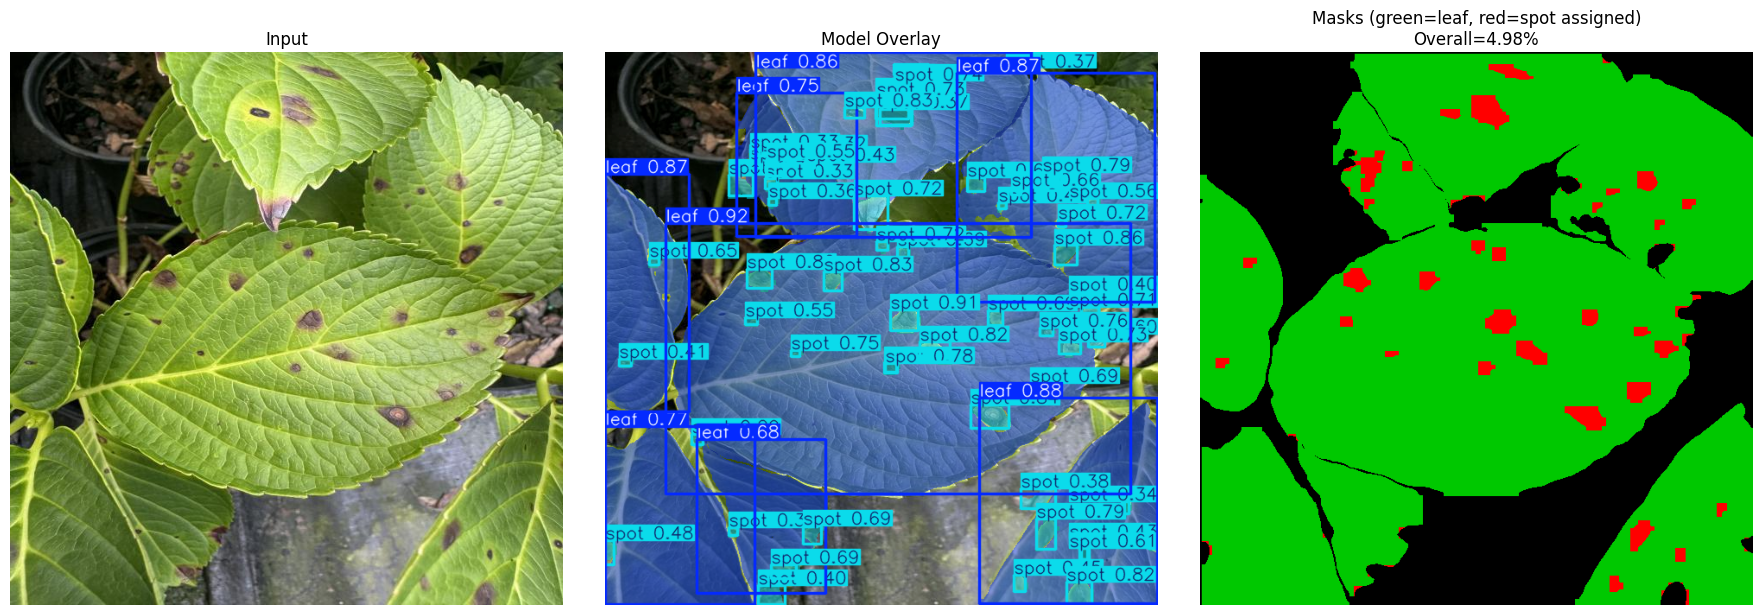

In [ ]:
# ===== Per-leaf spot percentage + aggregate =====
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

r = res[0]  # prediction result from Ultralytics
names = {int(k): v for k, v in model.names.items()} if isinstance(model.names, dict) else {i:n for i,n in enumerate(model.names)}

# --- 1) Get polygons per instance (original image coords) ---
if r.masks is None or r.boxes is None:
    raise RuntimeError("No masks/boxes returned. Ensure segmentation model and reasonable conf/imgsz.")

H, W = r.orig_img.shape[:2]
polys = r.masks.xy       # list of N arrays, each (num_points, 2) in original image coordinates
classes = r.boxes.cls.cpu().numpy().astype(int)

leaf_idx = [i for i,c in enumerate(classes) if names[c].lower() == "leaf"]
spot_idx = [i for i,c in enumerate(classes) if names[c].lower() == "spot"]

if not leaf_idx:
    raise RuntimeError("No leaf instances detected in this image.")
if not spot_idx:
    print("No spot instances detected. All leaves are 0.00%")
    # build per-leaf report with zeros anyway
    per_leaf = []
    for li in leaf_idx:
        per_leaf.append({"leaf_id": li, "leaf_pixels": 0, "spot_on_leaf_pixels": 0, "spot_pct_leaf": 0.0})
    print(per_leaf)
else:
    # --- 2) Rasterize polygons into boolean masks (one per instance) ---
    def poly_to_mask(poly_xy, h, w):
        # poly_xy: (N,2) ndarray in pixel coords
        im = Image.new('L', (w, h), 0)
        ImageDraw.Draw(im).polygon([tuple(p) for p in poly_xy], outline=1, fill=1)
        return np.array(im, dtype=bool)

    leaf_masks = []
    for li in leaf_idx:
        leaf_masks.append(poly_to_mask(polys[li], H, W))
    spot_masks = []
    for si in spot_idx:
        spot_masks.append(poly_to_mask(polys[si], H, W))

    leaf_masks = np.stack(leaf_masks, axis=0)  # [L,H,W]
    spot_masks = np.stack(spot_masks, axis=0)  # [S,H,W]

    L = leaf_masks.shape[0]
    S = spot_masks.shape[0]

    # --- 3) Assign each spot pixel to the single leaf with max overlap ---
    # Compute pixel overlap counts per (leaf, spot)
    # For memory efficiency, do per-spot
    leaf_pixels = leaf_masks.reshape(L, -1).sum(axis=1).astype(int)  # per-leaf area
    spot_assigned_on_leaf = np.zeros(L, dtype=np.int64)

    for s in range(S):
        sm = spot_masks[s]
        if not sm.any():
            continue
        # overlap with each leaf
        overlaps = [(leaf_masks[l] & sm).sum() for l in range(L)]
        l_best = int(np.argmax(overlaps))
        if overlaps[l_best] > 0:
            spot_assigned_on_leaf[l_best] += int(overlaps[l_best])
        # if no overlap, this spot is off-leaf; ignore for leaf % computation

    # --- 4) Per-leaf percentages & aggregate ---
    per_leaf = []
    total_leaf_pixels = 0
    total_spot_on_leaf = 0

    for idx_in_L, li in enumerate(leaf_idx):
        lp = int(leaf_pixels[idx_in_L])
        sp = int(spot_assigned_on_leaf[idx_in_L])
        pct = (100.0 * sp / lp) if lp > 0 else 0.0
        per_leaf.append({
            "leaf_id": int(li),  # original instance index
            "leaf_pixels": lp,
            "spot_on_leaf_pixels": sp,
            "spot_pct_leaf": round(pct, 3)
        })
        total_leaf_pixels += lp
        total_spot_on_leaf += sp

    overall_pct = (100.0 * total_spot_on_leaf / total_leaf_pixels) if total_leaf_pixels > 0 else 0.0

    # --- 5) Print results ---
    print("Per-leaf spot coverage (% of each leaf area):")
    for row in per_leaf:
        print(f"  leaf#{row['leaf_id']:>2}: {row['spot_pct_leaf']:6.3f}%  "
              f"(leaf_px={row['leaf_pixels']:,}, spot∩leaf_px={row['spot_on_leaf_pixels']:,})")

    print("\n=== Overall (area-weighted across all leaves) ===")
    print(f"Total leaf pixels:      {total_leaf_pixels:,}")
    print(f"Total spot-on-leaf px:  {total_spot_on_leaf:,}")
    print(f"Overall spot % (leaves): {overall_pct:.3f}%")

    # --- 6) Optional: quick visualization of assignments ---
    show_viz = True
    if show_viz:
        viz = np.zeros((H, W, 3), dtype=np.uint8)
        # color leaves in green, spots-on-leaf in red (assigned)
        for l in range(L):
            viz[leaf_masks[l]] = [0, 200, 0]
        # draw assigned spot pixels in red (overwrites green)
        # rebuild assigned per-spot mask for the chosen leaf
        for s in range(S):
            sm = spot_masks[s]
            overlaps = [(leaf_masks[l] & sm).sum() for l in range(L)]
            l_best = int(np.argmax(overlaps))
            if overlaps[l_best] > 0:
                viz[leaf_masks[l_best] & sm] = [255, 0, 0]

        plt.figure(figsize=(18,6))
        plt.subplot(1,3,1); plt.imshow(Image.open(img_path)); plt.axis("off"); plt.title("Input")
        plt.subplot(1,3,2); plt.imshow(overlay_rgb);         plt.axis("off"); plt.title("Model Overlay")
        plt.subplot(1,3,3); plt.imshow(viz);                 plt.axis("off"); plt.title(f"Masks (green=leaf, red=spot assigned)\nOverall={overall_pct:.2f}%")
        plt.tight_layout(); plt.show()

In [ ]:
# === Load a stronger CLIP, with safe fallbacks ===
import gc, torch, open_clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# cleanup any prior model
for var in ["clip_model", "model"]:
    if var in globals():
        try: del globals()[var]
        except: pass
torch.cuda.empty_cache(); gc.collect()

candidates = [
    ("ViT-L-14-336", "openai"),              # 336px OpenAI weights
    ("ViT-L-14",      "laion2b_s32b_b82k"),  # LAION L/14 (224px)
]

last_err = None
for model_name, pretrained in candidates:
    try:
        clip_model, _, preprocess = open_clip.create_model_and_transforms(
            model_name, pretrained=pretrained, device=device
        )
        tokenizer = open_clip.get_tokenizer(model_name)
        # (optional) use fp16 on GPU for memory/speed
        if device == "cuda":
            clip_model = clip_model.half()
        print(f"✅ Loaded CLIP {model_name}/{pretrained} on {device}")
        break
    except Exception as e:
        print(f"⚠️ Failed {model_name}/{pretrained}: {e}")
        last_err = e
else:
    raise RuntimeError(f"Could not load any CLIP model. Last error: {last_err}")

/home/myid/bp67339/myenv/lib/python3.10/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


✅ Loaded CLIP ViT-L-14-336/openai on cuda


Device: cuda
✅ Loaded 2836 train / 500 val
✅ Disease bank: ['Bacterial Leaf Scorch', 'Cercospora Leaf Spot', 'Dogwood Anthracnose', 'Phyllosticta Leaf Spot', 'Septoria Leaf Spot', 'Spot Anthracnose']
✅ Symptom phrases (sample): ['centered purple', 'bordered by faint yellow halos', 'purple rims', 'purple borders', 'bordered spots', 'edged spots', 'bordered by yellow halos', 'centered spots', 'angular or irregular', 'centered tan spots', 'centered tan lesions', 'rimmed spots', 'bordered by faint yellow lines', 'bordered tan spots', 'rimmed tan spots', 'despite watering', 'purple margins', 'leaving holes', 'purple edges', 'small tan']
✅ Loaded CLIP ViT-L-14-336/openai on cuda
✅ Using seg weights: runs/segment/train7/weights/best.pt
Found 53 image(s) in /home/myid/bp67339/plant_disease/data/test_images
🖼️ Using image: /home/myid/bp67339/plant_disease/data/test_images/PXL_20240628_210031755_jpg.rf.d4631f35c23a5327d9668493e87916ff.jpg
🟢 Found 2 leaf cutout(s).


/tmp/ipykernel_53503/2227942390.py:225: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(m_crop, mode="L").resize(crop.size, Image.NEAREST)


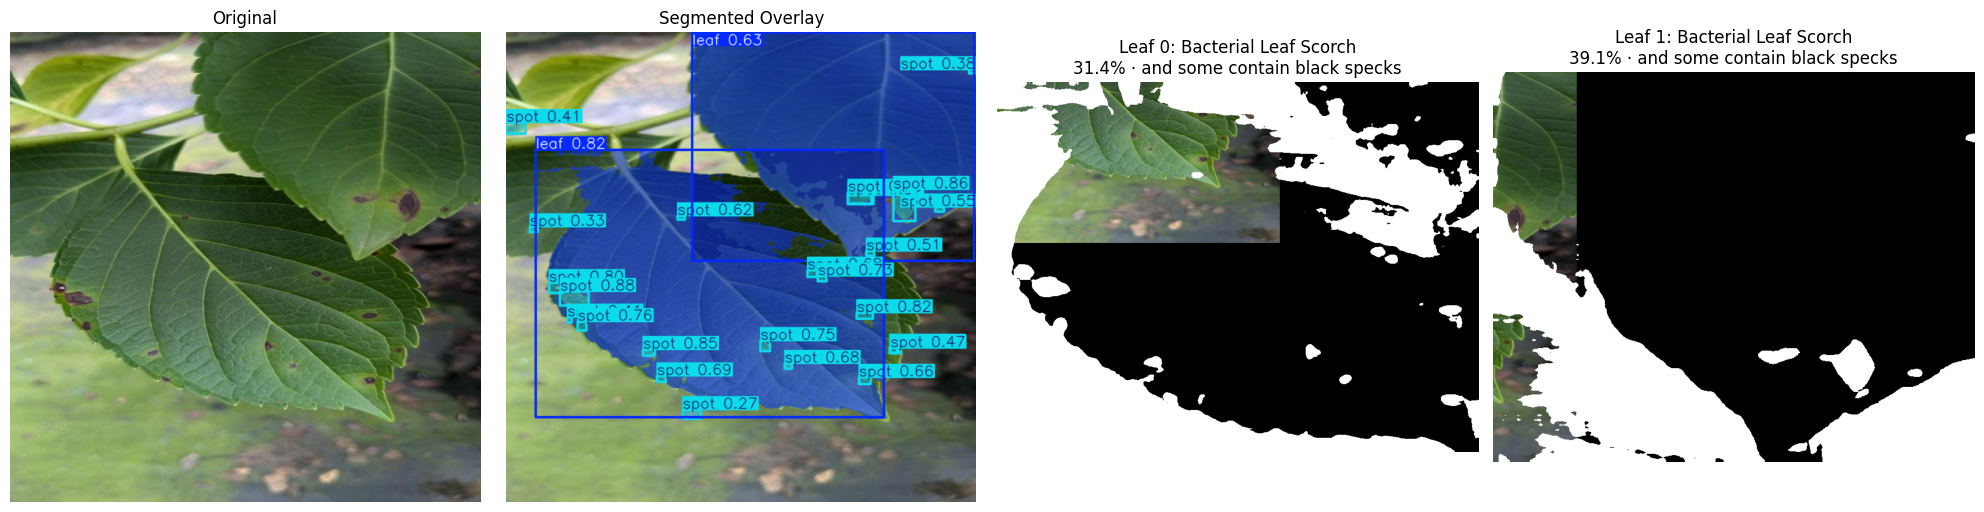


=== Leaf Cutout 0  bbox=(82, 322, 1033, 1053) ===
Description: Likely shows and some contain black specks, and many contain black specks and black specks are visible in many.
Image-evidence confidence: 31.4% (zero-shot relative)
Top symptoms:
  - and some contain black specks (7.3%)
  - and many contain black specks (4.0%)
  - black specks are visible in many (3.7%)
  - centered tan spots with purple rims (2.4%)
  - i noticed purple (2.4%)
Top diseases (sanity check):
  - Bacterial Leaf Scorch (31.4%)
  - Phyllosticta Leaf Spot (21.6%)
  - Cercospora Leaf Spot (20.9%)
  - Spot Anthracnose (10.4%)
  - Septoria Leaf Spot (9.7%)

=== Leaf Cutout 1  bbox=(506, 0, 1277, 625) ===
Description: Likely shows and some contain black specks, and many contain black specks and black specks are visible in many.
Image-evidence confidence: 39.1% (zero-shot relative)
Top symptoms:
  - and some contain black specks (4.9%)
  - and many contain black specks (3.6%)
  - black specks are visible in many (2.9

In [ ]:
# ======================================
# 0) Install (first run only) & Imports
# ======================================
# If your venv already has these, you can comment the next line out.
# !pip -q install ultralytics open-clip-torch pillow torch torchvision

import os, glob, json, re, math, numpy as np, torch, gc
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from ultralytics import YOLO
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ======================================
# 1) Load Text Banks from your UGA home
# ======================================
HOME      = "/home/myid/bp67339"
DATA_DIR = "/home/myid/bp67339/plant_disease/data"

train_file = f"{DATA_DIR}/plant_disease_text_finetune_train.jsonl"
val_file   = f"{DATA_DIR}/plant_disease_text_finetune_val.jsonl"

def read_jsonl(fp):
    data = []
    with open(fp, "r") as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = read_jsonl(train_file)
val_data   = read_jsonl(val_file)
print(f"✅ Loaded {len(train_data)} train / {len(val_data)} val")

# --- Disease bank ---
disease_texts = []
for ds in [train_data, val_data]:
    for e in ds:
        for line in e["completion"].split("\n"):
            if line.startswith("Disease:"):
                disease_texts.append(line.replace("Disease:", "").strip())
disease_texts = sorted(set(disease_texts))
print("✅ Disease bank:", disease_texts)

# --- Symptom phrase bank (short, visual) ---
symptom_texts = []
for ds in [train_data, val_data]:
    for e in ds:
        t = e["prompt"].split("Assistant:")[0]
        t = re.sub(r'^User:\s*', '', t).strip()
        symptom_texts.append(t)

DROP_PAT = re.compile(r'\b(what|which|could|please|help|identify|disease|treatment|manage|management|advise|suggest|why|how|thanks|thank)\b')
NUM_PAT  = re.compile(r'\b\d+(\.\d+)?\b')  # numbers like 16 or 1.5

def extract_phrases(texts, max_words=6):
    phrases = []
    for t in texts:
        t = t.lower()
        for c in re.split(r'[.,;:?!()\[\]/\-]', t):
            c = re.sub(r'\s+', ' ', c).strip()
            if not c: continue
            if DROP_PAT.search(c): continue
            w = c.split()
            if 2 <= len(w) <= max_words:
                phrases.append(c)
    return phrases

raw_phr = extract_phrases(symptom_texts, max_words=6)

bad_starts = ("on my", "by ", "in ", "after ", "before ", "each ", "every ", "over ", "during ", "this ", "my ", "our ")
visual_tokens = (
    "spot","spots","lesion","lesions","halo","halos","purple","red","tan","brown",
    "yellow","chlorosis","powdery","downy","rust","pustules","angular","vein","veins",
    "margins","borders","blotch","blotches","hole","holes","scorch","necrotic",
    "curl","curling","drop","dropping","ring","rings","speck","specks"
)

def looks_visual(p):
    if p.startswith(bad_starts): return False
    if p.startswith("the "):     return False
    if NUM_PAT.search(p):        return False
    return any(tok in p for tok in visual_tokens)

phr = [p for p in raw_phr if looks_visual(p)]
symptom_phrases = [p for p,_ in Counter(phr).most_common(120)]
print("✅ Symptom phrases (sample):", symptom_phrases[:20])

# ======================================
# 2) Load CLIP (ViT-L/14-336, openai) + helpers (with caching)
# ======================================
# Free older models if re-running
for var in ["clip_model"]:
    if var in globals():
        try: del globals()[var]
        except: pass
torch.cuda.empty_cache(); gc.collect()

model_name = "ViT-L-14-336"
pretrained = "openai"
clip_model, _, preprocess = open_clip.create_model_and_transforms(
    model_name, pretrained=pretrained, device=device
)
tokenizer = open_clip.get_tokenizer(model_name)
if device == "cuda":
    clip_model = clip_model.half()
print(f"✅ Loaded CLIP {model_name}/{pretrained} on {device}")

TEMPLATES = [
    "a photo of a leaf with {}",
    "a plant leaf showing {}",
    "a close-up of a leaf with {}",
    "a leaf exhibiting {}",
    "a macro photo of leaf {}"
]
TEXT_CACHE = {}

@torch.no_grad()
def encode_text_templates_cached(phrases, cache):
    out = []
    for phrase in phrases:
        key = (model_name, pretrained, phrase)
        if key not in cache:
            per_t = []
            for tmpl in TEMPLATES:
                s = tmpl.format(phrase)
                toks = tokenizer([s]).to(device)
                f = clip_model.encode_text(toks)
                f = f / f.norm(dim=-1, keepdim=True)
                per_t.append(f)
            cache[key] = torch.stack(per_t, dim=0).mean(dim=0)
        out.append(cache[key])
    return torch.cat(out, dim=0)

@torch.no_grad()
def clip_rank(image_tensor, phrases, topk=5):
    # fp16-friendly
    if device == "cuda" and next(clip_model.parameters()).dtype == torch.float16:
        image_tensor = image_tensor.half()
    img_f = clip_model.encode_image(image_tensor)
    img_f = img_f / img_f.norm(dim=-1, keepdim=True)
    txt_f = encode_text_templates_cached(phrases, TEXT_CACHE).to(img_f.device)
    if device == "cuda" and next(clip_model.parameters()).dtype == torch.float16:
        txt_f = txt_f.half()
    logits = 100.0 * img_f @ txt_f.T
    probs  = torch.softmax(logits, dim=-1).squeeze(0).cpu()
    idx = torch.argsort(probs, descending=True)[:topk]
    return [(phrases[i], float(probs[i])) for i in idx], float(probs[idx[0]])  # (phrase, prob), best prob

def compose_description(top_list, k=3):
    parts = [s for s,_ in top_list[:k]]
    if not parts: return "No clear visual cues detected."
    if len(parts)==1: return f"Likely shows {parts[0]}."
    return "Likely shows " + ", ".join(parts[:-1]) + " and " + parts[-1] + "."

# ======================================
# 3) Load YOLOv8-Seg (auto-find best.pt if path not set)
# ======================================
def find_latest_best():
    cands = glob.glob("runs/segment/*/weights/best.pt")
    if not cands: return None
    cands.sort(key=os.path.getmtime, reverse=True)
    return cands[0]

SEG_WEIGHTS = find_latest_best()  # auto
if SEG_WEIGHTS is None:
    raise FileNotFoundError("No seg weights found in runs/segment/*/weights/best.pt. Train YOLO or set SEG_WEIGHTS manually.")
print("✅ Using seg weights:", SEG_WEIGHTS)
seg_model = YOLO(SEG_WEIGHTS)
# ======================================
# 4) Choose an image → run SEG → transparent cutouts
# ======================================
IMG_PATH = None  # set to a specific file to force one image

if IMG_PATH is None:
    TEST_DIR = os.path.join(DATA_DIR, "test_images")  # <-- fixed (no extra "data")
    # be robust to different extensions/case
    exts = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
    test_images = []
    for ext in exts:
        test_images += glob.glob(os.path.join(TEST_DIR, ext))
    # quick sanity print to debug paths
    print(f"Found {len(test_images)} image(s) in {TEST_DIR}")
    assert len(test_images) > 0, f"No images found in {TEST_DIR}. Add a few .jpg/.png files."
    img_path = test_images[7]  # or: random.choice(test_images)
else:
    img_path = IMG_PATH

print("🖼️ Using image:", img_path)
orig = Image.open(img_path).convert("RGB")

overlay_img = None
leaf_cutouts = []   # list of PIL RGBA images (transparent background)
leaf_boxes   = []   # list of (x1,y1,x2,y2)

res = seg_model.predict(img_path, imgsz=1280, conf=0.20, verbose=False)
vis = res[0].plot()                      # BGR ndarray
overlay_img = Image.fromarray(vis[..., ::-1])

names = res[0].names
boxes = res[0].boxes
masks = res[0].masks

if masks is not None and boxes is not None:
    cls = boxes.cls.cpu().numpy().astype(int)
    leaf_ids = [i for i,k in names.items() if k.lower() in ("leaf","leaves")]

    for i, cid in enumerate(cls):
        if cid not in leaf_ids:
            continue
        m = masks.data[i].cpu().numpy()  # [H,W] float (0..1)
        ys, xs = np.where(m > 0.5)
        if len(xs)==0 or len(ys)==0:
            continue

        x1, x2 = int(xs.min()), int(xs.max())
        y1, y2 = int(ys.min()), int(ys.max())

        crop = orig.crop((x1, y1, x2, y2))

        m_crop  = (m[y1:y2, x1:x2] > 0.5).astype(np.uint8) * 255
        mask_pil = Image.fromarray(m_crop, mode="L").resize(crop.size, Image.NEAREST)

        cutout = crop.convert("RGBA")
        cutout.putalpha(mask_pil)   # transparent background outside leaf

        leaf_cutouts.append(cutout)
        leaf_boxes.append((x1, y1, x2, y2))

print(f"🟢 Found {len(leaf_cutouts)} leaf cutout(s).")

# Fallback if nothing detected: keep lists in sync
if not leaf_cutouts:
    leaf_cutouts = [orig.convert("RGBA")]
    leaf_boxes   = [(0,0,orig.width, orig.height)]

# sanity check to avoid IndexError later
assert len(leaf_cutouts) == len(leaf_boxes), f"Cutouts ({len(leaf_cutouts)}) and boxes ({len(leaf_boxes)}) out of sync"

# ======================================
# 5) CLIP on EACH LEAF CUTOUT
# ======================================
results = []
for idx, im_rgba in enumerate(leaf_cutouts):
    # RGBA -> RGB for CLIP
    im_rgb = im_rgba.convert("RGB")
    clip_input = preprocess(im_rgb).unsqueeze(0).to(device)

    top_sym, img_conf_sym = clip_rank(clip_input, symptom_phrases, topk=5)
    top_dis, img_conf_dis = clip_rank(clip_input, disease_texts,    topk=min(5, len(disease_texts)))
    desc = compose_description(top_sym, k=3)
    img_conf = round(max(img_conf_sym, img_conf_dis)*100, 1)

    results.append({
        "index": idx,
        "bbox": leaf_boxes[idx],
        "desc": desc,
        "img_conf": img_conf,
        "symptoms": top_sym,
        "diseases": top_dis
    })

# ======================================
# 6) Visualization: Original → Overlay → All Cutouts with captions
# ======================================
def short(s, n=30):
    return (s[:n] + "…") if len(s) > n else s

cols = max(2, min(5, len(leaf_cutouts)+2))
rows = math.ceil((2 + len(leaf_cutouts)) / cols)
plt.figure(figsize=(5*cols, 5*rows))

# Original
plt.subplot(rows, cols, 1); plt.imshow(orig); plt.axis("off"); plt.title("Original")

# Overlay (if any)
slot = 2
if overlay_img is not None:
    plt.subplot(rows, cols, slot); slot += 1
    plt.imshow(overlay_img); plt.axis("off"); plt.title("Segmented Overlay")

# Cutouts
for r in results:
    plt.subplot(rows, cols, slot); slot += 1
    plt.imshow(leaf_cutouts[r["index"]]); plt.axis("off")
    d0 = r["diseases"][0][0] if r["diseases"] else "—"
    s0 = short(r["symptoms"][0][0]) if r["symptoms"] else "—"
    plt.title(f"Leaf {r['index']}: {d0}\n{r['img_conf']}% · {s0}")

plt.tight_layout()
plt.show()

# ======================================
# 7) Print a concise per-cutout report
# ======================================
for r in results:
    print(f"\n=== Leaf Cutout {r['index']}  bbox={r['bbox']} ===")
    print("Description:", r["desc"])
    print(f"Image-evidence confidence: {r['img_conf']}% (zero-shot relative)")
    print("Top symptoms:")
    for t,p in r["symptoms"]:
        print(f"  - {t} ({p*100:.1f}%)")
    print("Top diseases (sanity check):")
    for t,p in r["diseases"]:
        print(f"  - {t} ({p*100:.1f}%)")

# ======================================
# 8) Save cutouts (PNG to preserve transparency)
# ======================================
OUT_CUT = f"{DATA_DIR}/leaf_cutouts"
os.makedirs(OUT_CUT, exist_ok=True)
for i, im in enumerate(leaf_cutouts):
    outp = f"{OUT_CUT}/cutout_{i}.png"
    im.save(outp)
print("\n💾 Saved cutouts to", OUT_CUT)

In [ ]:
# ============================================
# UGA server: Train DeBERTa v3 text classifier (train + val)
# ============================================
# If your venv lacks packages, uncomment the next line:
# !pip install -U transformers accelerate datasets scikit-learn evaluate

import os, re, json, numpy as np
from collections import Counter
from sklearn.metrics import classification_report

HOME      = "/home/myid/bp67339"
DATA_DIR  = f"{HOME}/plant_disease/data"
TRAIN_FP  = f"{DATA_DIR}/plant_disease_text_finetune_train.jsonl"
VAL_FP    = f"{DATA_DIR}/plant_disease_text_finetune_val.jsonl"
OUT_DIR   = f"{HOME}/plant_disease/models/deberta_v3_base_textclf"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Load JSONL ----------
def read_jsonl(fp):
    rows = []
    with open(fp, "r") as f:
        for line in f:
            rows.append(json.loads(line))
    return rows

train_rows = read_jsonl(TRAIN_FP)
val_rows   = read_jsonl(VAL_FP)

# ---------- Extract (text, label) ----------
# - text: entry["prompt"] before "Assistant:"
# - label: line starting with "Disease:" in entry["completion"]
def extract_pairs(rows):
    X, y = [], []
    for e in rows:
        t = e["prompt"].split("Assistant:")[0]
        t = re.sub(r'^User:\s*', '', t).strip()
        disease = None
        for line in e["completion"].split("\n"):
            if line.startswith("Disease:"):
                disease = line.replace("Disease:", "").strip()
                break
        if t and disease:
            X.append(t)
            y.append(disease)
    return X, y

X_train, y_train = extract_pairs(train_rows)
X_val,   y_val   = extract_pairs(val_rows)
print(f"Train size: {len(X_train)} | Val size: {len(X_val)}")

# ---------- Labels ----------
labels     = sorted(list(set(y_train + y_val)))
label2id   = {l:i for i,l in enumerate(labels)}
id2label   = {i:l for l,i in label2id.items()}
y_train_i  = [label2id[l] for l in y_train]
y_val_i    = [label2id[l] for l in y_val]
num_labels = len(labels)
print("Labels:", labels)

# ---------- Class weights (to handle imbalance) ----------
from collections import Counter
counts = Counter(y_train_i)
total  = sum(counts.values())
class_weights = np.array([
    total / (counts[i] if counts[i] > 0 else 1)
    for i in range(num_labels)
], dtype=np.float32)
class_weights = class_weights / class_weights.mean()
print("Class weights:", class_weights.round(2))

# ---------- HF Datasets ----------
from datasets import Dataset, DatasetDict
ds_train = Dataset.from_dict({"text": X_train, "label": y_train_i})
ds_val   = Dataset.from_dict({"text": X_val,   "label": y_val_i})
raw_ds   = DatasetDict({"train": ds_train, "validation": ds_val})

# ---------- Tokenizer / Model ----------
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)  # <- add use_fast=False
MAX_LEN   = 256

def tok_fn(batch):
    return tokenizer(batch["text"], padding="max_length",
                     truncation=True, max_length=MAX_LEN)

tok_ds = raw_ds.map(tok_fn, batched=True, remove_columns=["text"])
tok_ds = tok_ds.rename_column("label", "labels")
tok_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# ---------- Trainer (no eval_strategy; manual eval after) ----------
import torch
from transformers import Trainer, TrainingArguments

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fct = torch.nn.CrossEntropyLoss(
            weight=torch.tensor(class_weights, dtype=torch.float32).to(self.model.device)
        ) if class_weights is not None else torch.nn.CrossEntropyLoss()

    # accept possible num_items_in_batch kwarg for newer HF versions
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels  = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits  = outputs.logits
        loss    = self.loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

train_bs = 16
args = TrainingArguments(
    output_dir=OUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=train_bs,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=1000,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to=[]  # disable W&B
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"],
    tokenizer=tokenizer,
    class_weights=class_weights
)

print("🚀 Starting training…")
trainer.train()

# ---------- Save model & labels ----------
trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)
with open(os.path.join(OUT_DIR, "labels.json"), "w") as f:
    json.dump({"labels": labels}, f, indent=2)
print(f"\n✅ Training complete. Model saved to: {OUT_DIR}")

# ---------- Manual evaluation on validation ----------
pred = trainer.predict(tok_ds["validation"])
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=-1)
print("\n=== Validation report ===")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_labels)], digits=3))

# ---------- Inference helper ----------
import torch.nn.functional as F
def predict(text: str, topk: int = 3):
    model.eval()
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LEN)
    enc = {k: v.to(model.device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
        probs = F.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
    idx = probs.argsort()[::-1][:topk]
    return [(id2label[i], float(probs[i])) for i in idx]

# Quick smoke test
print("\nSmoke test:")
ex = "Dogwood leaf with tan-centered, purple-bordered angular spots and early leaf drop after humid weeks."
print(predict(ex, topk=3))

In [ ]:
# === Phase-2 fine-tuning: make classifier robust to prompt variations ===
import re, numpy as np, torch
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, set_seed,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader

BASE_MODEL_DIR = "/home/myid/bp67339/plant_disease/models/deberta_v3_base_textclf"
TRAIN_JSONL    = "/home/myid/bp67339/plant_disease/data/plant_disease_text_finetune_train_aug15_merged.jsonl"
VAL_JSONL      = "/home/myid/bp67339/plant_disease/data/plant_disease_text_finetune_val_aug15_merged.jsonl"
OUT_DIR        = "/home/myid/bp67339/plant_disease/models/deberta_v3_base_textclf_phase2"

set_seed(42)

# 1) Load tokenizer + model from your already-trained classifier
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_DIR, use_fast=False)  # avoids SP byte-fallback warning
model     = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_DIR)

# Sanity: label maps from your first training (keeps label IDs consistent)
id2label  = dict(getattr(model.config, "id2label", {}))
label2id  = dict(getattr(model.config, "label2id", {}))
assert id2label and label2id, "Model config must contain id2label/label2id from phase-1."

# 2) Load augmented JSONL (prompt/completion) and convert to classification labels
train_raw = Dataset.from_json(TRAIN_JSONL)
val_raw   = Dataset.from_json(VAL_JSONL)

# Parse "Disease: XYZ" from completion, map to label id using model.config.label2id keys
disease_pat = re.compile(r"^\s*Disease:\s*([^\n\r]+)", re.IGNORECASE)

def add_label(example):
    comp = example.get("completion", "") or ""
    m = disease_pat.search(comp)
    disease = (m.group(1).strip() if m else None)
    if disease in label2id:
        y = int(label2id[disease])
    else:
        norm = disease.replace("  ", " ").strip() if disease else None
        y = int(label2id[norm]) if (norm in label2id) else -1
    return {"text": example.get("prompt", ""), "label": y}

train_labeled = train_raw.map(add_label, remove_columns=[c for c in train_raw.column_names if c not in ("prompt","completion")])
val_labeled   = val_raw.map(add_label,   remove_columns=[c for c in val_raw.column_names   if c not in ("prompt","completion")])

# Filter out rows where label couldn't be mapped
train_labeled = train_labeled.filter(lambda ex: ex["label"] != -1)
val_labeled   = val_labeled.filter(lambda ex: ex["label"] != -1)

print("Train size after mapping:", len(train_labeled))
print("Val size after mapping:", len(val_labeled))
print("Label set (id2label):", id2label)

# 3) Tokenize (no padding here; we’ll use a dynamic collator)
def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, max_length=512)

train_tok = train_labeled.map(preprocess, batched=True)
val_tok   = val_labeled.map(preprocess,   batched=True)

# Make sure Trainer sees the label column
train_tok = train_tok.rename_column("label", "labels")
val_tok   = val_tok.rename_column("label", "labels")

# Torch format for efficient loading
train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_tok.set_format(type="torch",   columns=["input_ids", "attention_mask", "labels"])

# 4) Metrics
label_names = [id2label[i] for i in range(len(id2label))]

def compute_metrics(eval_pred):
    logits = eval_pred.predictions[0] if isinstance(eval_pred.predictions, tuple) else eval_pred.predictions
    preds = np.argmax(logits, axis=-1)
    labels = eval_pred.label_ids
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average="macro")
    f1_per_class = f1_score(labels, preds, average=None, labels=list(range(len(label_names))))
    metrics = {"accuracy": acc, "f1_macro": f1m}
    for i, name in enumerate(label_names):
        metrics[f"f1_{name}"] = float(f1_per_class[i])
    return metrics

# 5) Training args — small LR to retain prior knowledge; frequent logging for visibility
fp16_ok = torch.cuda.is_available()
args = TrainingArguments(
    output_dir=OUT_DIR,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-6,
    num_train_epochs=2,
    logging_steps=10,
    logging_first_step=True,
    disable_tqdm=False,
    save_steps=2000,
    eval_steps=2000,
    save_total_limit=2,
    dataloader_num_workers=2,
    fp16=fp16_ok,                 # AMP if available
    remove_unused_columns=False,
)

# Dynamic padding collator (also used in the sanity-check DataLoader)
pad_to_mult = 8 if fp16_ok else None
collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=pad_to_mult)

# 6) Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=collator,       # <— important
    compute_metrics=compute_metrics,
)

# Optional quick sanity batch using the same collator
dl = DataLoader(train_tok, batch_size=8, shuffle=False, collate_fn=collator)
batch = next(iter(dl))
print({k: tuple(v.shape) for k, v in batch.items()})

# 7) Train → Evaluate → Save
trainer.train()
eval_metrics = trainer.evaluate()
print("🧪 Eval metrics:", eval_metrics)

trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)
print("✅ Phase-2 fine-tuning complete. Saved to:", OUT_DIR)

In [ ]:
# ============================================
# Faster inference: GPU, half/bfloat16, shorter seq, warmup
# ============================================
import os, json, time, numpy as np, torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def pick_dtype():
    if torch.cuda.is_available():
        # Prefer bf16 on Ampere+ (A100/A10/RTX 30/40) if supported; else fp16
        if torch.cuda.is_bf16_supported():
            return torch.bfloat16
        else:
            return torch.float16
    return torch.float32

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = pick_dtype()

# (Optional) move model to fast local disk first, if current dir is slow/NFS
TEXT_MODEL_DIR = "/home/myid/bp67339/plant_disease/models/deberta_v3_base_textclf_phase2"
# e.g., copy once to /scratch and point there for faster loads:
# TEXT_MODEL_DIR = "/scratch/bp67339/deberta_v3_base_textclf_phase2"

print("📦 Using text model from:", TEXT_MODEL_DIR)
print("🖥️ device:", device, "| dtype:", dtype)

tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL_DIR, local_files_only=True, use_fast=True)

# Load with low CPU mem pressure; then cast on GPU
t0 = time.time()
model = AutoModelForSequenceClassification.from_pretrained(
    TEXT_MODEL_DIR, local_files_only=True, use_safetensors=True
)
model.eval()
if device == "cuda":
    model.to(device)
    # cast weights for speed (bf16 preferred if supported)
    if dtype is torch.float16:
        model.half()
    elif dtype is torch.bfloat16:
        model.to(dtype=dtype)

t1 = time.time()
print(f"⏱️ model load: {(t1 - t0):.2f}s")

# Load label order
with open(os.path.join(TEXT_MODEL_DIR, "labels.json")) as f:
    labels = json.load(f)["labels"]
id2label = {i: l for i, l in enumerate(labels)}

# Keep this small unless you truly need long text
MAX_LEN = 160

@torch.inference_mode()  # faster than no_grad for inference
def predict_one(text: str, topk: int = 3):
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=MAX_LEN
    )
    enc = {k: v.to(device, non_blocking=True) for k, v in enc.items()}

    # Warmup (first call initializes CUDA kernels etc.)
    # Do one cheap dry run per session if needed
    # _ = model(**enc)

    logits = model(**enc).logits
    if device == "cuda" and dtype in (torch.float16, torch.bfloat16):
        logits = logits.to(torch.float32)  # softmax in fp32 for numeric stability
    probs  = F.softmax(logits, dim=-1).squeeze(0).detach().cpu().numpy()
    idx    = probs.argsort()[::-1][:topk]
    return [(id2label[i], float(probs[i])) for i in idx], probs

# --- timing demo ---
text = "Leaves show tan-centered, purple-rimmed angular spots with early drop after humid weeks."

# Warmup once (important on GPU)
_ = predict_one("warmup", topk=1)

t2 = time.time()
topk_pred, _ = predict_one(text, topk=3)
t3 = time.time()

print("Top-3:", topk_pred)
print(f"⏱️ inference time: {(t3 - t2):.3f}s (after warmup)")

📦 Using text model from: /home/myid/bp67339/plant_disease/models/deberta_v3_base_textclf_phase2
🖥️ device: cuda | dtype: torch.bfloat16
⏱️ model load: 0.21s
Top-3: [('Phyllosticta Leaf Spot', 0.9978602528572083), ('Dogwood Anthracnose', 0.0017676937859505415), ('Septoria Leaf Spot', 0.00017917598597705364)]
⏱️ inference time: 0.015s (after warmup)


In [ ]:
# =========================
# Fusion with Weather Prior
# =========================
import os, json, re, numpy as np
import torch
import torch.nn.functional as F
from typing import List, Tuple, Dict, Any, Optional
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# -------- Paths --------
HOME = "/home/myid/bp67339"
DATA_DIR = f"{HOME}/plant_disease/data"
WEATHER_KB_PATH = f"{DATA_DIR}/kb_leaf_spots.json"

CANDIDATE_TEXT_DIRS = [
    f"{HOME}/plant_disease/models/deberta_v3_base_textclf_phase2",  # phase-2
    f"{HOME}/plant_disease/models/deberta_v3_base_textclf",         # fallback
]
FEATS_JSON_PATH = f"{DATA_DIR}/last_weather_feats.json"

def load_saved_weather_feats(path: str = FEATS_JSON_PATH) -> Dict[str, Any]:
    with open(path, "r") as f:
        return json.load(f)
TEXT_MODEL_DIR = next((p for p in CANDIDATE_TEXT_DIRS if os.path.isdir(p)), None)
assert TEXT_MODEL_DIR, f"Could not find text model dir. Checked: {CANDIDATE_TEXT_DIRS}"

# -------- Utilities --------
def read_jsonl(fp: str) -> List[Dict[str, Any]]:
    out = []
    with open(fp, "r") as f:
        for line in f:
            if line.strip():
                out.append(json.loads(line))
    return out

def _norm(s: str) -> str:
    return re.sub(r"\s+", " ", s.strip().lower())

def _softmax(x, tau=1.0, eps=1e-12):
    x = np.asarray(x, dtype=np.float64)
    x = x / max(tau, 1e-8)
    x = x - x.max()
    e = np.exp(x)
    return e / (e.sum() + eps)

# -------- Build disease_texts from training JSONLs (canonical names used by image pipeline) --------
train_file = f"{DATA_DIR}/plant_disease_text_finetune_train.jsonl"
val_file   = f"{DATA_DIR}/plant_disease_text_finetune_val.jsonl"
assert os.path.isfile(train_file) and os.path.isfile(val_file), "Missing train/val jsonl in DATA_DIR"

disease_texts: List[str] = []
for ds in (read_jsonl(train_file), read_jsonl(val_file)):
    for e in ds:
        for line in e.get("completion", "").split("\n"):
            if line.startswith("Disease:"):
                disease_texts.append(line.replace("Disease:", "").strip())
disease_texts = sorted(set(disease_texts), key=lambda s: s.lower())

# -------- Load text classifier --------
device = "cuda" if torch.cuda.is_available() else "cpu"
text_tok   = AutoTokenizer.from_pretrained(TEXT_MODEL_DIR, use_fast=False)
text_model = AutoModelForSequenceClassification.from_pretrained(TEXT_MODEL_DIR).to(device).eval()

id2label = {int(k): v for k, v in text_model.config.id2label.items()}
label2id = {v: int(k) for k, v in id2label.items()}
labels_model = [id2label[i] for i in range(len(id2label))]

# -------- Load weather KB + names --------
with open(WEATHER_KB_PATH, "r") as f:
    kb = json.load(f)
kb_names = [d["name"] for d in kb["diseases"]]

# -------- Unified disease universe (stable order) --------
DISEASE_UNIVERSE = sorted(set(disease_texts) | set(kb_names) | set(labels_model),
                          key=lambda s: s.lower())
U = len(DISEASE_UNIVERSE)

# Mappings into the universe
name_to_uix = {_norm(n): i for i, n in enumerate(DISEASE_UNIVERSE)}
def map_vector(names: List[str], probs: np.ndarray) -> np.ndarray:
    vec = np.zeros(U, dtype=np.float64)
    for n, p in zip(names, probs):
        i = name_to_uix.get(_norm(n))
        if i is not None:
            vec[i] = float(p)
    s = vec.sum()
    return vec / (s + 1e-12) if s > 0 else np.ones(U)/U

# -------- Text prediction → probs in universe --------
MAX_LEN = 256
@torch.no_grad()
def _text_probs_universe(user_text: str, tau_text: float = 1.0) -> np.ndarray:
    enc = text_tok(user_text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LEN).to(device)
    logits = text_model(**enc).logits
    p = F.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
    # map text model label space → universe
    return map_vector(labels_model, p)

# -------- Image (CLIP) aggregation → probs in universe --------
def clip_probs_from_results(results: List[Dict[str, Any]], tau_img: float = 1.0) -> np.ndarray:
    """
    results: each item like {"diseases": [("Label A", 0.82), ("Label B", 0.34), ...]}
    """
    if not results:
        return np.ones(U, dtype=np.float64) / U
    # take per-leaf max across same label, then max across leaves
    per_leaf = []
    for r in results:
        leaf = np.zeros(U, dtype=np.float64)
        for label, prob in r.get("diseases", []):
            j = name_to_uix.get(_norm(label))
            if j is not None:
                leaf[j] = max(leaf[j], float(prob))
        per_leaf.append(leaf)
    agg = np.maximum.reduce(per_leaf) if per_leaf else np.zeros(U)
    agg = _softmax(agg, tau_img)
    return agg / (agg.sum() + 1e-12)

# -------- Weather prior helpers (hardened) --------
_ALLOWED = set(list("0123456789.+-*/()<>=! &|") + list("_") +
               list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"))

def _rule_true(expr: str, feats: Dict[str, Any]) -> bool:
    s = expr.replace("&&", " and ").replace("||", " or ")
    if any(ch not in _ALLOWED for ch in s):
        return False
    for k, v in feats.items():
        try:
            fv = float(v)
        except (TypeError, ValueError):
            continue
        s = re.sub(rf"\b{k}\b", str(fv), s)
    try:
        return bool(eval(s, {"__builtins__": {}}, {}))
    except Exception:
        return False

def _score_weather_for_disease(d_entry: Dict[str, Any], feats: Dict[str, Any]) -> float:
    sc = 0.0
    for r in d_entry.get("scoring", {}).get("rules", []):
        cond, add = r.get("if", ""), float(r.get("add", 0.0))
        if cond and _rule_true(cond, feats):
            sc += add
    cap = float(d_entry.get("scoring", {}).get("cap", 1.0))
    return max(0.0, min(cap, sc))

# Build a weather prior (in the **universe** order) from features (dict) and KB file
def build_weather_prior_from_feats(feats: Dict[str, Any],
                                   kb_path: str = WEATHER_KB_PATH,
                                   floor: float = 0.05) -> np.ndarray:
    with open(kb_path, "r") as f:
        kb_local = json.load(f)
    kb_by_name = {_norm(d["name"]): d for d in kb_local["diseases"]}
    pw = np.zeros(U, dtype=np.float64)
    for i, name in enumerate(DISEASE_UNIVERSE):
        d = kb_by_name.get(_norm(name))
        if d is None:
            pw[i] = floor
        else:
            pw[i] = max(floor, float(_score_weather_for_disease(d, feats)))
    pw /= (pw.sum() + 1e-12)
    return pw

# -------- Visual-boost heuristic (optional) --------
VISUAL_CUES = [
    "purple border","purple rim","yellow halo","tan spot","tan lesion",
    "angular spot","holes","shot hole","chlorosis","powdery","downy",
    "pustules","leaf drop","defoliation","black dots","pycnidia",
    "black/brown dots","brown dots"
]
def visual_boost(text: str) -> float:
    t = text.lower()
    hits = sum(1 for k in VISUAL_CUES if k in t)
    return min(0.15, 0.04 * hits)

# -------- Fusion --------
def fuse_predict(
    user_text: str,
    results: List[Dict[str, Any]],
    feats_weather: Optional[Dict[str, Any]] = None,  # features from Weather_Feature_Pipeline
    weather_prior: Optional[np.ndarray] = None,      # OR pass a precomputed prior in universe order
    w_text: float = 0.65,
    w_img: float  = 0.35,
    w_wx: float   = 0.40,     # weather strength when applied
    tau_text: float = 1.0,
    tau_img:  float = 0.9,
    wx_floor: float = 0.05,
    gate_margin: float = 0.05,  # apply weather only if (top1 - top2) < margin
    topk: int = 5
) -> Tuple[List[Tuple[str, float, float, float, float]], Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
    """
    Returns:
      top list of (label, P_final, P_text, P_img, P_wx) in DISEASE_UNIVERSE
      and full vectors (pt, pi, pw, pf)
    """
    # text + image
    pt = _text_probs_universe(user_text, tau_text=tau_text)
    pi = clip_probs_from_results(results, tau_img=tau_img)

    # optional visual boost to image weight
    vb = visual_boost(user_text)
    w_img = min(0.7, w_img + vb)
    w_text = 1.0 - w_img
    w_text, w_img = float(np.clip(w_text, 0.0, 1.0)), float(np.clip(w_img, 0.0, 1.0))
    if w_text + w_img <= 0:
        w_text = w_img = 0.5

    eps = 1e-12
    log_p_imgtext = w_text * np.log(pt + eps) + w_img * np.log(pi + eps)
    p_imgtext = _softmax(log_p_imgtext, tau=1.0)

    # weather prior (universe order)
    if weather_prior is not None:
        pw = np.asarray(weather_prior, dtype=np.float64)
        if pw.shape[0] != U:
            raise ValueError(f"weather_prior length {pw.shape[0]} != universe size {U}")
        pw = pw / (pw.sum() + eps)
    elif feats_weather is not None:
        pw = build_weather_prior_from_feats(feats_weather, WEATHER_KB_PATH, floor=wx_floor)
    else:
        pw = np.ones(U, dtype=np.float64) / U

    # gating: only apply weather if img+text is not confident
    order_tmp = np.argsort(-p_imgtext)
    margin = float(p_imgtext[order_tmp[0]] - (p_imgtext[order_tmp[1]] if len(order_tmp) > 1 else 0.0))
    use_weather = (margin < gate_margin)

    if use_weather:
        log_pf = np.log(p_imgtext + eps) + w_wx * np.log(pw + eps)
    else:
        log_pf = np.log(p_imgtext + eps)
    pf = _softmax(log_pf, tau=1.0)

    idx = np.argsort(-pf)[:topk]
    top = [(DISEASE_UNIVERSE[i], float(pf[i]), float(pt[i]), float(pi[i]), float(pw[i])) for i in idx]
    return top, (pt, pi, pw, pf)

print("✅ Fusion (with weather prior) ready.")
print(f"Universe size: {len(DISEASE_UNIVERSE)} classes")

✅ Fusion (with weather prior) ready.
Universe size: 11 classes


In [ ]:
# ========= Combo runner: text / image / weather and mixes =========
def _normalize(p: np.ndarray) -> np.ndarray:
    p = np.asarray(p, dtype=np.float64)
    s = p.sum()
    return p / (s + 1e-12) if s > 0 else np.ones_like(p) / len(p)

def _combine_product_of_experts(components: List[Tuple[np.ndarray, float]]) -> np.ndarray:
    """components = [(prob_vec, weight_exponent), ...] ; weight=0 means ignore."""
    eps = 1e-12
    logp = None
    for p, w in components:
        if w is None or w == 0:
            continue
        p = _normalize(p)
        term = float(w) * np.log(p + eps)
        logp = term if logp is None else logp + term
    if logp is None:
        return np.ones(len(DISEASE_UNIVERSE)) / len(DISEASE_UNIVERSE)
    return _softmax(logp, tau=1.0)

def compute_modal_probs(
    user_text: str,
    results: List[Dict[str, Any]],
    feats_weather: Dict[str, Any],
    tau_text: float = 1.0,
    tau_img: float = 0.9,
    wx_floor: float = 0.05
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (pt, pi, pw) all aligned to DISEASE_UNIVERSE."""
    pt = _text_probs_universe(user_text, tau_text=tau_text)
    pi = clip_probs_from_results(results, tau_img=tau_img)
    pw = build_weather_prior_from_feats(feats_weather, WEATHER_KB_PATH, floor=wx_floor)
    return _normalize(pt), _normalize(pi), _normalize(pw)

def run_all_combos(
    user_text: str,
    results: List[Dict[str, Any]],
    feats_weather: Dict[str, Any],
    w_text: float = 0.65,
    w_img:  float = 0.35,
    w_wx:   float = 0.40,
    tau_text: float = 1.0,
    tau_img: float  = 0.9,
    topk: int = 7
):
    pt, pi, pw = compute_modal_probs(user_text, results, feats_weather,
                                     tau_text=tau_text, tau_img=tau_img)

    combos = {
        "text_only":             _normalize(pt),
        "image_only":            _normalize(pi),
        "weather_only":          _normalize(pw),
        "image+text":            _combine_product_of_experts([(pt, w_text), (pi, w_img)]),
        "text+weather":          _combine_product_of_experts([(pt, w_text), (pw, w_wx)]),
        "weather+image":         _combine_product_of_experts([(pw, w_wx),  (pi, w_img)]),
        "image+text+weather":    _combine_product_of_experts([(pt, w_text), (pi, w_img), (pw, w_wx)]),
    }

    # pretty print
    for name, p in combos.items():
        idx = np.argsort(-p)[:topk]
        print(f"\n=== {name} (top-{topk}) ===")
        for i in idx:
            print(f"{DISEASE_UNIVERSE[i]:55s}  p={p[i]:.3f}")

    return combos, (pt, pi, pw)

In [ ]:
# Example inputs
user_text = "Hydrangea leaves with tan-centered purple-rimmed spots; several leaves dropped after humid week."
image_results = []  # or [{"diseases":[("Septoria Leaf Spot",0.62),("Cercospora Leaf Spot",0.41)]}]

# Load the latest features saved by Weather_Feature_Pipeline.ipynb
feats_weather = load_saved_weather_feats()  # reads DATA_DIR/last_weather_feats.json
print("Loaded weather features from JSON:", len(feats_weather), "fields")

top, (pt, pi, pw, pf) = fuse_predict(
    user_text=user_text,
    results=image_results,
    feats_weather=feats_weather,     # ← uses the saved features
    w_text=0.65, w_img=0.35, w_wx=0.40,
    gate_margin=0.05,                # set very large (e.g., 1e9) if you want weather ALWAYS applied with your current fuse_predict
    topk=7
)

print("\n=== Final fused ranking ===")
for name, p_final, p_text, p_img, p_wx in top:
    print(f"{name:55s}  final={p_final:6.3f}  text={p_text:6.3f}  image={p_img:6.3f}  wx={p_wx:6.3f}")

Loaded weather features from JSON: 14 fields

=== Final fused ranking ===
Phyllosticta Leaf Spot                                   final= 0.869  text= 0.964  image= 0.091  wx= 0.022
Dogwood Anthracnose                                      final= 0.091  text= 0.030  image= 0.091  wx= 0.022
Spot Anthracnose                                         final= 0.031  text= 0.006  image= 0.091  wx= 0.022
Bacterial Leaf Scorch                                    final= 0.003  text= 0.000  image= 0.091  wx= 0.022
Cercospora Leaf Spot                                     final= 0.003  text= 0.000  image= 0.091  wx= 0.109
Septoria Leaf Spot                                       final= 0.003  text= 0.000  image= 0.091  wx= 0.130
Bacterial Leaf Spot (Hydrangea)                          final= 0.000  text= 0.000  image= 0.091  wx= 0.130


In [ ]:
# Load latest saved feats from Weather_Feature_Pipeline
feats_weather = load_saved_weather_feats()
print("Loaded weather features:", len(feats_weather))

user_text = "Hydrangea leaves with tan-centered purple-rimmed spots; several leaves dropped after humid week."
image_results = []  # or [{"diseases":[("Septoria Leaf Spot",0.62),("Cercospora Leaf Spot",0.41)]}]

# weights you want to compare with (same as before)
w_text, w_img, w_wx = 0.65, 0.35, 0.40

combos, (pt, pi, pw) = run_all_combos(
    user_text=user_text,
    results=image_results,
    feats_weather=feats_weather,
    w_text=w_text, w_img=w_img, w_wx=w_wx,
    tau_text=1.0, tau_img=0.9,
    topk=7
)

Loaded weather features: 14

=== text_only (top-7) ===
Phyllosticta Leaf Spot                                   p=0.964
Dogwood Anthracnose                                      p=0.030
Spot Anthracnose                                         p=0.006
Bacterial Leaf Scorch                                    p=0.000
Cercospora Leaf Spot                                     p=0.000
Septoria Leaf Spot                                       p=0.000
Bacterial Leaf Spot (Hydrangea)                          p=0.000

=== image_only (top-7) ===
Anthracnose (leaf spot/blight on Hydrangea)              p=0.091
Bacterial Leaf Scorch                                    p=0.091
Bacterial Leaf Scorch (physiological look-alike)         p=0.091
Bacterial Leaf Spot (Hydrangea)                          p=0.091
Cercospora Leaf Spot                                     p=0.091
Dogwood Anthracnose                                      p=0.091
Phyllosticta Leaf Spot                                   p=0.091

=== we